# Models
In this notebook we will generate several different models using the already engineered features. We will then evaluate the models using cross validation and select the best model to use for our predictions.

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [25]:
GEO = 'texas_florida'
df = pd.read_csv(f'../../data/processed/features_{GEO}_no_tsne_no_doubles.csv')
df.index = df["review_id"]
df.drop(columns=["review_id"], inplace=True)

print(df.shape)
df.head()

(1629, 111)


,embedding_comments_0,embedding_comments_1,embedding_comments_2,embedding_comments_3,embedding_comments_4,embedding_comments_5,embedding_comments_6,embedding_comments_7,embedding_comments_8,embedding_comments_9,...,amenityall_dishwasher,amenityall_silverware,amenityall_bathtub,amenityall_lockbox,amenityall_crib,amenityall_elevator,amenityall_gym,amenityall_oven,amenityall_toilet,label
review_id,,,,,,,,,,,,,,,,,,,,,
83097,0.17,-0.64,0.61,-0.14,0.11,-0.26,0.94,1.33,-0.96,-0.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
133337,0.17,-0.57,0.55,-0.22,0.19,-0.43,0.80,1.32,-0.83,-0.91,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
150928,0.09,-0.68,0.64,-0.13,0.07,-0.22,1.04,1.25,-1.00,-0.70,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
2706775,0.09,-0.68,0.69,-0.22,0.11,-0.35,0.96,1.55,-0.99,-0.72,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
8602878,0.18,-0.51,0.67,-0.20,0.05,-0.16,0.95,1.28,-0.94,-0.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good


In [26]:
df.label.value_counts()

good     1320
mbad      118
mgood     105
bad        84
Name: label, dtype: int64

Drop NA labels... THANKS Charlie :/

In [27]:
df = df.dropna()

The data is extremely imbalanced. We can use the `imbalanced-learn` Python library, which has several implementations of resampling methods to deal with this problem. We will use the `SMOTE` method, which oversamples the minority class.

In [28]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(df.drop(columns=["label"]), df["label"])

print("Balanced labels:")
y.value_counts()

Balanced labels:


good     1320
mgood    1320
mbad     1320
bad      1320
Name: label, dtype: int64

## Testing out different feature combinations
We want to try the different combinations of features to see which ones work best.

In [29]:
import itertools

feature_sets = [
    # "tsne2_comments_2D_",
    # "tsne3_comments_3D_",
    # "tsne2_description_2D_",
    # "tsne3_description_3D_",
    "embedding_comments_",
    "embedding_description_",
    "3gram09_",
    "3gram10_",
    "amenity005_",
    "amenityall_"
]

# get all combinations of feature sets of all lengths
feature_sets_combinations = []
for i in range(1, len(feature_sets) + 1):
    feature_sets_combinations += [list(x) for x in itertools.combinations(feature_sets, i)]

print(f"Number of feature sets combinations: {len(feature_sets_combinations)}")

Number of feature sets combinations: 63


In [30]:
from lazypredict.Supervised import LazyClassifier

top_models = {}
best_model = None
best_accuracy = -1
best_feature_set = None

num_of_feature_sets_combinations = len(feature_sets_combinations)

for i, feature_sets_combination in enumerate(feature_sets_combinations):

    print(f"Testing feature sets combination {i + 1} of {num_of_feature_sets_combinations} ({feature_sets_combination})")

    # get column subset
    df_subset_columns = [c for c in df.columns if any([c.startswith(f) for f in feature_sets_combination])]
    df_subset_columns.append("label")

    # oversample and get train/test split
    df_subset = df[df_subset_columns]
    X, y = oversample.fit_resample(df_subset.drop(columns=["label"]), df_subset["label"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train model
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    top_models_for_subset = models.sort_values(by="Accuracy", ascending=False).head(10)

    top_model = models.iloc[0]
    accuracy = top_model["Accuracy"]
    name = top_model.name
    print(f"Top model for {feature_sets_combination}: {name}. Accuracy = {accuracy}")
    if top_model["Accuracy"] > best_accuracy:
        best_accuracy = top_model["Accuracy"]
        best_model = top_model
        best_feature_set = feature_sets_combination
        print(f"New best model found! Accuracy = {accuracy}")

    # save results
    top_models[",".join(feature_sets_combination)] = top_models_for_subset

    print()


print(f"Best model: {best_model.name} with feature set {best_feature_set}\nAccuracy = {best_accuracy}")

import pickle
# save top_models
with open(f"../../data/processed/top_models_{GEO}_no_tsne.pickle", "wb") as f:
    pickle.dump(top_models, f)

Testing feature sets combination 1 of 63 (['embedding_comments_'])


100%|██████████| 29/29 [00:07<00:00,  3.70it/s]


Top model for ['embedding_comments_']: ExtraTreesClassifier. Accuracy = 0.9498106060606061
New best model found! Accuracy = 0.9498106060606061

Testing feature sets combination 2 of 63 (['embedding_description_'])


100%|██████████| 29/29 [00:08<00:00,  3.62it/s]


Top model for ['embedding_description_']: ExtraTreesClassifier. Accuracy = 0.8096590909090909

Testing feature sets combination 3 of 63 (['3gram09_'])


100%|██████████| 29/29 [00:10<00:00,  2.67it/s]


Top model for ['3gram09_']: NearestCentroid. Accuracy = 0.2803030303030303

Testing feature sets combination 4 of 63 (['3gram10_'])


100%|██████████| 29/29 [00:04<00:00,  6.44it/s]


Top model for ['3gram10_']: QuadraticDiscriminantAnalysis. Accuracy = 0.2755681818181818

Testing feature sets combination 5 of 63 (['amenity005_'])


100%|██████████| 29/29 [00:07<00:00,  4.07it/s]


Top model for ['amenity005_']: RandomForestClassifier. Accuracy = 0.3787878787878788

Testing feature sets combination 6 of 63 (['amenityall_'])


100%|██████████| 29/29 [00:10<00:00,  2.71it/s]


Top model for ['amenityall_']: RandomForestClassifier. Accuracy = 0.4753787878787879

Testing feature sets combination 7 of 63 (['embedding_comments_', 'embedding_description_'])


100%|██████████| 29/29 [00:10<00:00,  2.71it/s]


Top model for ['embedding_comments_', 'embedding_description_']: ExtraTreesClassifier. Accuracy = 0.9630681818181818
New best model found! Accuracy = 0.9630681818181818

Testing feature sets combination 8 of 63 (['embedding_comments_', '3gram09_'])


100%|██████████| 29/29 [00:13<00:00,  2.09it/s]


Top model for ['embedding_comments_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.9517045454545454

Testing feature sets combination 9 of 63 (['embedding_comments_', '3gram10_'])


100%|██████████| 29/29 [00:08<00:00,  3.51it/s]


Top model for ['embedding_comments_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9535984848484849

Testing feature sets combination 10 of 63 (['embedding_comments_', 'amenity005_'])


100%|██████████| 29/29 [00:09<00:00,  2.97it/s]


Top model for ['embedding_comments_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9517045454545454

Testing feature sets combination 11 of 63 (['embedding_comments_', 'amenityall_'])


100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


Top model for ['embedding_comments_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9507575757575758

Testing feature sets combination 12 of 63 (['embedding_description_', '3gram09_'])


100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Top model for ['embedding_description_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.8238636363636364

Testing feature sets combination 13 of 63 (['embedding_description_', '3gram10_'])


100%|██████████| 29/29 [00:08<00:00,  3.30it/s]


Top model for ['embedding_description_', '3gram10_']: RandomForestClassifier. Accuracy = 0.8238636363636364

Testing feature sets combination 14 of 63 (['embedding_description_', 'amenity005_'])


100%|██████████| 29/29 [00:10<00:00,  2.71it/s]


Top model for ['embedding_description_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8702651515151515

Testing feature sets combination 15 of 63 (['embedding_description_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  1.94it/s]


Top model for ['embedding_description_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.896780303030303

Testing feature sets combination 16 of 63 (['3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Top model for ['3gram09_', '3gram10_']: BernoulliNB. Accuracy = 0.27367424242424243

Testing feature sets combination 17 of 63 (['3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


Top model for ['3gram09_', 'amenity005_']: LGBMClassifier. Accuracy = 0.35700757575757575

Testing feature sets combination 18 of 63 (['3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Top model for ['3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.48200757575757575

Testing feature sets combination 19 of 63 (['3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:07<00:00,  3.86it/s]


Top model for ['3gram10_', 'amenity005_']: RandomForestClassifier. Accuracy = 0.3873106060606061

Testing feature sets combination 20 of 63 (['3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:12<00:00,  2.31it/s]


Top model for ['3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.4895833333333333

Testing feature sets combination 21 of 63 (['amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Top model for ['amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.48579545454545453

Testing feature sets combination 22 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_'])


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.96875
New best model found! Accuracy = 0.96875

Testing feature sets combination 23 of 63 (['embedding_comments_', 'embedding_description_', '3gram10_'])


100%|██████████| 29/29 [00:10<00:00,  2.69it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9715909090909091
New best model found! Accuracy = 0.9715909090909091

Testing feature sets combination 24 of 63 (['embedding_comments_', 'embedding_description_', 'amenity005_'])


100%|██████████| 29/29 [00:12<00:00,  2.31it/s]


Top model for ['embedding_comments_', 'embedding_description_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9753787878787878
New best model found! Accuracy = 0.9753787878787878

Testing feature sets combination 25 of 63 (['embedding_comments_', 'embedding_description_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.90it/s]


Top model for ['embedding_comments_', 'embedding_description_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9640151515151515

Testing feature sets combination 26 of 63 (['embedding_comments_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


Top model for ['embedding_comments_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9535984848484849

Testing feature sets combination 27 of 63 (['embedding_comments_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:16<00:00,  1.80it/s]


Top model for ['embedding_comments_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9488636363636364

Testing feature sets combination 28 of 63 (['embedding_comments_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.55it/s]


Top model for ['embedding_comments_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9535984848484849

Testing feature sets combination 29 of 63 (['embedding_comments_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


Top model for ['embedding_comments_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9611742424242424

Testing feature sets combination 30 of 63 (['embedding_comments_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:13<00:00,  2.19it/s]


Top model for ['embedding_comments_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9517045454545454

Testing feature sets combination 31 of 63 (['embedding_comments_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


Top model for ['embedding_comments_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9526515151515151

Testing feature sets combination 32 of 63 (['embedding_description_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:15<00:00,  1.87it/s]


Top model for ['embedding_description_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8153409090909091

Testing feature sets combination 33 of 63 (['embedding_description_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Top model for ['embedding_description_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8825757575757576

Testing feature sets combination 34 of 63 (['embedding_description_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Top model for ['embedding_description_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9015151515151515

Testing feature sets combination 35 of 63 (['embedding_description_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.62it/s]


Top model for ['embedding_description_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8816287878787878

Testing feature sets combination 36 of 63 (['embedding_description_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  2.00it/s]


Top model for ['embedding_description_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9043560606060606

Testing feature sets combination 37 of 63 (['embedding_description_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.80it/s]


Top model for ['embedding_description_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9034090909090909

Testing feature sets combination 38 of 63 (['3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:14<00:00,  1.98it/s]


Top model for ['3gram09_', '3gram10_', 'amenity005_']: DecisionTreeClassifier. Accuracy = 0.3712121212121212

Testing feature sets combination 39 of 63 (['3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.61it/s]


Top model for ['3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.5018939393939394

Testing feature sets combination 40 of 63 (['3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:19<00:00,  1.45it/s]


Top model for ['3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.5037878787878788

Testing feature sets combination 41 of 63 (['3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Top model for ['3gram10_', 'amenity005_', 'amenityall_']: NuSVC. Accuracy = 0.48390151515151514

Testing feature sets combination 42 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:17<00:00,  1.66it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9725378787878788

Testing feature sets combination 43 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:18<00:00,  1.53it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9734848484848485

Testing feature sets combination 44 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9668560606060606

Testing feature sets combination 45 of 63 (['embedding_comments_', 'embedding_description_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9715909090909091

Testing feature sets combination 46 of 63 (['embedding_comments_', 'embedding_description_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.74it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9640151515151515

Testing feature sets combination 47 of 63 (['embedding_comments_', 'embedding_description_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.54it/s]


Top model for ['embedding_comments_', 'embedding_description_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9706439393939394

Testing feature sets combination 48 of 63 (['embedding_comments_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:16<00:00,  1.78it/s]


Top model for ['embedding_comments_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9583333333333334

Testing feature sets combination 49 of 63 (['embedding_comments_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


Top model for ['embedding_comments_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9554924242424242

Testing feature sets combination 50 of 63 (['embedding_comments_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:20<00:00,  1.45it/s]


Top model for ['embedding_comments_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.946969696969697

Testing feature sets combination 51 of 63 (['embedding_comments_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Top model for ['embedding_comments_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9583333333333334

Testing feature sets combination 52 of 63 (['embedding_description_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Top model for ['embedding_description_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8797348484848485

Testing feature sets combination 53 of 63 (['embedding_description_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Top model for ['embedding_description_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8977272727272727

Testing feature sets combination 54 of 63 (['embedding_description_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


Top model for ['embedding_description_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8958333333333334

Testing feature sets combination 55 of 63 (['embedding_description_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.76it/s]


Top model for ['embedding_description_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9043560606060606

Testing feature sets combination 56 of 63 (['3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Top model for ['3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.4990530303030303

Testing feature sets combination 57 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:19<00:00,  1.52it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9744318181818182

Testing feature sets combination 58 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.96875

Testing feature sets combination 59 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.28it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9630681818181818

Testing feature sets combination 60 of 63 (['embedding_comments_', 'embedding_description_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.65it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9696969696969697

Testing feature sets combination 61 of 63 (['embedding_comments_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Top model for ['embedding_comments_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9621212121212122

Testing feature sets combination 62 of 63 (['embedding_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Top model for ['embedding_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8958333333333334

Testing feature sets combination 63 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.26it/s]

Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9668560606060606

Best model: ExtraTreesClassifier with feature set ['embedding_comments_', 'embedding_description_', 'amenity005_']
Accuracy = 0.9753787878787878


In [34]:
import pickle
top_models = pickle.load(open(f"../../models/top_models_{GEO}_no_tsne.pickle", "rb"))

report = []

feature_set_to_letter = {
    "embedding_comments_": "(A)",
    "embedding_description_": "(B)",
    "amenity005_" : "(C)",
    "amenityall_" : "(D)",
    "3gram09_" : "(E)",
    "3gram10_" : "(F)",
    
}

# iterate over keys and values
for key, value in top_models.items():
    top_model_name = value.iloc[0].name
    top_model_accuracy = value.iloc[0]["Accuracy"]

    report.append({
        "feature_set": ", ".join([feature_set_to_letter[f] for f in key.split(",")]),
        "top_model_name": top_model_name,
        "top_model_accuracy": top_model_accuracy
    })

top = pd.DataFrame(report).sort_values(by="top_model_accuracy", ascending=False)
top.head(10)

,feature_set,top_model_name,top_model_accuracy
23,"(A), (B), (C)",ExtraTreesClassifier,0.98
56,"(A), (B), (E), (F), (C)",ExtraTreesClassifier,0.97
42,"(A), (B), (E), (C)",ExtraTreesClassifier,0.97
41,"(A), (B), (E), (F)",ExtraTreesClassifier,0.97
44,"(A), (B), (F), (C)",ExtraTreesClassifier,0.97
22,"(A), (B), (F)",ExtraTreesClassifier,0.97
46,"(A), (B), (C), (D)",ExtraTreesClassifier,0.97
59,"(A), (B), (F), (C), (D)",ExtraTreesClassifier,0.97
57,"(A), (B), (E), (F), (D)",ExtraTreesClassifier,0.97
21,"(A), (B), (E)",ExtraTreesClassifier,0.97


# Compare Results

Let's see which features appear the most in models that perform over 80% accuracy.

There are 36 models above 90% accuracy


<AxesSubplot: xlabel='% of top models using feature set', ylabel='Feature set'>

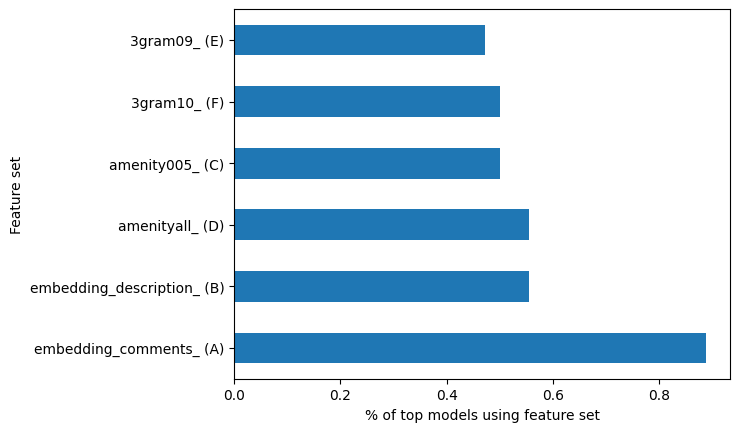

In [35]:
# split feature_set into individual feature sets
letters = ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"]
top["feature_set_split"] = top["feature_set"].apply(lambda x: x.split(", "))
for letter in ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"]:
    top[letter] = top["feature_set_split"].apply(lambda x: letter in x)

# lets see what percent of the top models have each feature set (top models will be above 80% accuracy)
with_accuracy = top[["top_model_accuracy"] + letters]
models_above_90_accuracy = with_accuracy[with_accuracy.top_model_accuracy > 0.9]
print(f"There are {models_above_90_accuracy.shape[0]} models above 90% accuracy")
feature_set_distr = models_above_90_accuracy.sum().drop("top_model_accuracy").sort_values(ascending=False) / models_above_90_accuracy.shape[0]


# convert back to feature set name
# reverse feature_set_to_letter
feature_set_to_letter = {v: k for k, v in feature_set_to_letter.items()}
feature_set_distr.index = feature_set_distr.index.map(lambda x: feature_set_to_letter[x] + " " + x)
feature_set_distr.plot(kind="barh", xlabel="% of top models using feature set", ylabel="Feature set")

Let's grab the best subset, and hyperparameter tune the best model!

In [36]:
top_feature_set = top.reset_index().iloc[0].feature_set.split(", ")
top_feature_set = [feature_set_to_letter[f] for f in top_feature_set]
top_feature_set

['embedding_comments_', 'embedding_description_', 'amenity005_']

In [37]:
columns_in_best_feature_set = [c for c in df.columns if any([c.startswith(f) for f in top_feature_set])]
columns_in_best_feature_set.append("label")

df_best_subset = df[columns_in_best_feature_set]

print("Best feature set:")
print(columns_in_best_feature_set)


Best feature set:
['embedding_comments_0', 'embedding_comments_1', 'embedding_comments_2', 'embedding_comments_3', 'embedding_comments_4', 'embedding_comments_5', 'embedding_comments_6', 'embedding_comments_7', 'embedding_comments_8', 'embedding_comments_9', 'embedding_description_0', 'embedding_description_1', 'embedding_description_2', 'embedding_description_3', 'embedding_description_4', 'embedding_description_5', 'embedding_description_6', 'embedding_description_7', 'embedding_description_8', 'embedding_description_9', 'amenity005_lockbox', 'amenity005_dishwasher', 'amenity005_pool', 'amenity005_stove', 'amenity005_keypad', 'amenity005_bathtub', 'amenity005_kitchen', 'amenity005_balcony', 'amenity005_shampoo', 'amenity005_garden', 'amenity005_cat', 'amenity005_family', 'amenity005_breakfast', 'label']


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.97


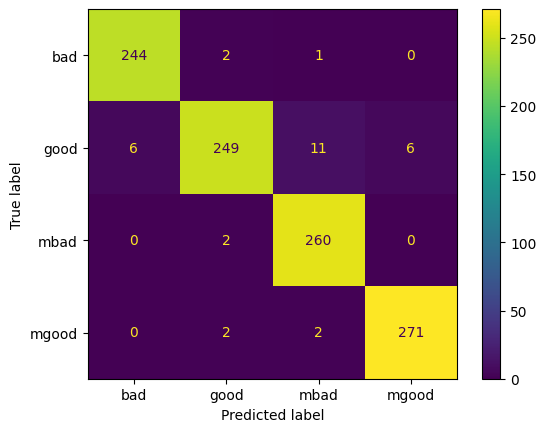

In [40]:
# load ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

# apply GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
}

clf = GridSearchCV(ExtraTreesClassifier(), params, cv=5, n_jobs=-1, verbose=1)

# oversample and get train/test split
X, y = oversample.fit_resample(df_best_subset.drop(columns=["label"]), df_best_subset["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# print the best parameters
print("Best parameters:")
print(clf.best_params_)

# predict
y_pred = best_clf.predict(X_test)

# evaluate
from sklearn.metrics import accuracy_score

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Save the model along with functions to generate features

In [32]:
pickle.dump({
    "best_clf": best_clf,
    "best_feature_set": columns_in_best_feature_set,
}, open(f"best_clf_{GEO}.pickle", "wb"))